<a href="https://colab.research.google.com/github/rapu34/A1_performance_factory_Aveners/blob/main/A_B_Test_20230131.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb
import gc

In [2]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20180306-3).
0 upgraded, 0 newly installed, 0 to remove and 27 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 10 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/n

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
bidding = pd.read_csv("/content/drive/MyDrive/A1project/bidding_result.csv", encoding='UTF8')

In [5]:
indexs = list(set(bidding['index'].to_list()))
print(len(indexs))

48896


In [6]:
idx_distinct_df = bidding.drop_duplicates(['index'])
idx_distinct_df

,index,Impression,Click,Cost,Sum of AD rank,Bid,Price(PC),Price(Mobile),Delivery Fee,Category Name 1,Category Name 2,Category Name 3,Category Name 4,date
0,3575092,3,0,0.0,3.000000,50,165900,165900,0,가구/인테리어,침실가구,장롱/붙박이장,드레스룸,20221031
1,3575637,6,0,0.0,3.333333,50,10900,10900,0,가구/인테리어,인테리어소품,아로마/캔들용품,아로마방향제/디퓨저,20221031
2,4129259,7,0,0.0,8.000000,50,255000,255000,-1,가구/인테리어,거실가구,소파,패브릭소파,20221031
3,4131479,36,3,150.0,4.416667,140,190000,190000,20000,가구/인테리어,아동/주니어가구,책상의자세트,NaN,20221031
4,4131482,224,0,0.0,5.696429,50,129000,129000,0,가구/인테리어,아동/주니어가구,책상,NaN,20221031
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1337083,2566795,5,0,0.0,13.200000,500,19900,19900,0,가구/인테리어,인테리어소품,아로마/캔들용품,아로마방향제/디퓨저,20230103
1337084,2566880,3,0,0.0,17.000000,500,23900,23900,3000,생활/건강,문구/사무용품,이벤트/파티용품,데코용품,20230103
1337085,2566881,1,0,0.0,8.000000,500,2500,2500,3000,가구/인테리어,인테리어소품,기타장식용품,NaN,20230103
1337086,2566891,2,0,0.0,4.000000,500,21000,21000,3000,생활/건강,정원/원예용품,화분받침,NaN,20230103


In [7]:
bidding['Sum of AD rank'] = bidding['Sum of AD rank'].round(0)
bidding['Sum of AD rank'] # rank 살리자 -가설: 특정 rank 구간에 click 까지만 유의미한 결과가 나타났다. 
#확인 2-4등일때 click 이 가장 많음
# 여성 상품의 경우 유의미한 순위 확인

0           3.0
1           3.0
2           8.0
3           4.0
4           6.0
           ... 
1337083    13.0
1337084    17.0
1337085     8.0
1337086     4.0
1337087    12.0
Name: Sum of AD rank, Length: 1337088, dtype: float64

In [8]:
# 날짜 데이터 테이트타임으로 바꾸기
def _trans_date_time(bidding):
    bidding.index = pd.to_datetime(bidding['date'], format='%Y%m%d')
    bidding.drop('date', axis=1, inplace=True)
    return bidding

In [9]:
_trans_date_time(bidding)


,index,Impression,Click,Cost,Sum of AD rank,Bid,Price(PC),Price(Mobile),Delivery Fee,Category Name 1,Category Name 2,Category Name 3,Category Name 4
date,,,,,,,,,,,,,
2022-10-31,3575092,3,0,0.0,3.0,50,165900,165900,0,가구/인테리어,침실가구,장롱/붙박이장,드레스룸
2022-10-31,3575637,6,0,0.0,3.0,50,10900,10900,0,가구/인테리어,인테리어소품,아로마/캔들용품,아로마방향제/디퓨저
2022-10-31,4129259,7,0,0.0,8.0,50,255000,255000,-1,가구/인테리어,거실가구,소파,패브릭소파
2022-10-31,4131479,36,3,150.0,4.0,140,190000,190000,20000,가구/인테리어,아동/주니어가구,책상의자세트,NaN
2022-10-31,4131482,224,0,0.0,6.0,50,129000,129000,0,가구/인테리어,아동/주니어가구,책상,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-01-03,2566795,5,0,0.0,13.0,500,19900,19900,0,가구/인테리어,인테리어소품,아로마/캔들용품,아로마방향제/디퓨저
2023-01-03,2566880,3,0,0.0,17.0,500,23900,23900,3000,생활/건강,문구/사무용품,이벤트/파티용품,데코용품
2023-01-03,2566881,1,0,0.0,8.0,500,2500,2500,3000,가구/인테리어,인테리어소품,기타장식용품,NaN


In [10]:
# CTR = 클릭률
# CPC = 클릭당 비용
# CPM = 1000회 노출당 비용
bidding["CTR"] = (bidding["Click"]/bidding["Impression"]) * 100
bidding["CPC"] = (bidding["Cost"]/bidding["Click"])
bidding["CPM"] = (bidding["Cost"]/1000)

###결측치 처리

In [11]:
# null값 퍼센트로 보기
(bidding.isnull().sum()/ bidding.shape[0]).sort_values(ascending=False)

CPC                0.753309
Category Name 4    0.304360
Category Name 3    0.004388
Sum of AD rank     0.000007
index              0.000000
Impression         0.000000
Click              0.000000
Cost               0.000000
Bid                0.000000
Price(PC)          0.000000
Price(Mobile)      0.000000
Delivery Fee       0.000000
Category Name 1    0.000000
Category Name 2    0.000000
CTR                0.000000
CPM                0.000000
dtype: float64

In [12]:
"""
Category Name 3, Sum of AD rank 는 결측치 자료가 적어서 drop한다
CPC의 결측치는 우선 0 으로 처리하고 다른 EDA를 해본다

"""

bidding2 = bidding.copy()
bidding2['Category Name 4'].fillna('uncategory', inplace = True)
bidding2['CPC'].fillna(0, inplace = True)
bidding2.dropna(axis = 0, inplace = True)
print(bidding2.isnull().sum().sort_values(ascending=False)) # null값 퍼센트로 표현
bidding2

index              0
Impression         0
Click              0
Cost               0
Sum of AD rank     0
Bid                0
Price(PC)          0
Price(Mobile)      0
Delivery Fee       0
Category Name 1    0
Category Name 2    0
Category Name 3    0
Category Name 4    0
CTR                0
CPC                0
CPM                0
dtype: int64


,index,Impression,Click,Cost,Sum of AD rank,Bid,Price(PC),Price(Mobile),Delivery Fee,Category Name 1,Category Name 2,Category Name 3,Category Name 4,CTR,CPC,CPM
date,,,,,,,,,,,,,,,,
2022-10-31,3575092,3,0,0.0,3.0,50,165900,165900,0,가구/인테리어,침실가구,장롱/붙박이장,드레스룸,0.000000,0.0,0.00
2022-10-31,3575637,6,0,0.0,3.0,50,10900,10900,0,가구/인테리어,인테리어소품,아로마/캔들용품,아로마방향제/디퓨저,0.000000,0.0,0.00
2022-10-31,4129259,7,0,0.0,8.0,50,255000,255000,-1,가구/인테리어,거실가구,소파,패브릭소파,0.000000,0.0,0.00
2022-10-31,4131479,36,3,150.0,4.0,140,190000,190000,20000,가구/인테리어,아동/주니어가구,책상의자세트,uncategory,8.333333,50.0,0.15
2022-10-31,4131482,224,0,0.0,6.0,50,129000,129000,0,가구/인테리어,아동/주니어가구,책상,uncategory,0.000000,0.0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-01-03,2566795,5,0,0.0,13.0,500,19900,19900,0,가구/인테리어,인테리어소품,아로마/캔들용품,아로마방향제/디퓨저,0.000000,0.0,0.00
2023-01-03,2566880,3,0,0.0,17.0,500,23900,23900,3000,생활/건강,문구/사무용품,이벤트/파티용품,데코용품,0.000000,0.0,0.00
2023-01-03,2566881,1,0,0.0,8.0,500,2500,2500,3000,가구/인테리어,인테리어소품,기타장식용품,uncategory,0.000000,0.0,0.00


In [13]:
# TIp
# 베이지안 a/b test? 왜 베이지안을 선택했는가 를 포트폴리오로  쓰기 장점 -> 
# 상황에 대한 맞춤으로 포트폴리오 스토리 만들기

In [14]:
bidding3 = bidding2.drop_duplicates(['index'])
bidding3

,index,Impression,Click,Cost,Sum of AD rank,Bid,Price(PC),Price(Mobile),Delivery Fee,Category Name 1,Category Name 2,Category Name 3,Category Name 4,CTR,CPC,CPM
date,,,,,,,,,,,,,,,,
2022-10-31,3575092,3,0,0.0,3.0,50,165900,165900,0,가구/인테리어,침실가구,장롱/붙박이장,드레스룸,0.000000,0.0,0.00
2022-10-31,3575637,6,0,0.0,3.0,50,10900,10900,0,가구/인테리어,인테리어소품,아로마/캔들용품,아로마방향제/디퓨저,0.000000,0.0,0.00
2022-10-31,4129259,7,0,0.0,8.0,50,255000,255000,-1,가구/인테리어,거실가구,소파,패브릭소파,0.000000,0.0,0.00
2022-10-31,4131479,36,3,150.0,4.0,140,190000,190000,20000,가구/인테리어,아동/주니어가구,책상의자세트,uncategory,8.333333,50.0,0.15
2022-10-31,4131482,224,0,0.0,6.0,50,129000,129000,0,가구/인테리어,아동/주니어가구,책상,uncategory,0.000000,0.0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-01-03,2566795,5,0,0.0,13.0,500,19900,19900,0,가구/인테리어,인테리어소품,아로마/캔들용품,아로마방향제/디퓨저,0.000000,0.0,0.00
2023-01-03,2566880,3,0,0.0,17.0,500,23900,23900,3000,생활/건강,문구/사무용품,이벤트/파티용품,데코용품,0.000000,0.0,0.00
2023-01-03,2566881,1,0,0.0,8.0,500,2500,2500,3000,가구/인테리어,인테리어소품,기타장식용품,uncategory,0.000000,0.0,0.00


In [15]:
categorys1 = list(set(bidding3['Category Name 1'].to_list()))
categorys2 = list(set(bidding3['Category Name 2'].to_list()))
categorys3 = list(set(bidding3['Category Name 3'].to_list()))
categorys4 = list(set(bidding3['Category Name 4'].to_list()))

In [16]:
# CTR = 클릭률
# CPC = 클릭당 비용
# CPM = 1000회 노출당 비용
for cate in categorys1:
    df = bidding3.loc[bidding3['Category Name 1'] == cate]
    print(f"CTR : {cate}: {df['CTR'].mean()}")
print('-' * 50)
for cate in categorys1:
    df = bidding3.loc[bidding3['Category Name 1'] == cate]
    print(f"CPC : {cate}: {df['CPC'].mean()}")
print('-' * 50)
for cate in categorys1:
    df = bidding3.loc[bidding3['Category Name 1'] == cate]
    print(f"CPM : {cate}: {df['CPM'].mean()}")
print('-' * 50)


CTR : 패션잡화: 1.7142804235347056
CTR : 디지털/가전: 1.916043896440929
CTR : 출산/육아: 2.3485914213997328
CTR : 식품: 0.0
CTR : 여가/생활편의: 4.306358289042499
CTR : 화장품/미용: 1.2639134068914868
CTR : 스포츠/레저: 2.473615329335076
CTR : 패션의류: 1.1696922649345287
CTR : 가구/인테리어: 1.534402497955175
CTR : 생활/건강: 1.816915281585836
--------------------------------------------------
CPC : 패션잡화: 68.05678756462889
CPC : 디지털/가전: 32.55504258551301
CPC : 출산/육아: 52.6338680538919
CPC : 식품: 0.0
CPC : 여가/생활편의: 38.62139917695473
CPC : 화장품/미용: 65.26291993796862
CPC : 스포츠/레저: 61.13637438132432
CPC : 패션의류: 92.61124449779913
CPC : 가구/인테리어: 47.029295871442436
CPC : 생활/건강: 56.909235795186234
--------------------------------------------------
CPM : 패션잡화: 0.17357933579335794
CPM : 디지털/가전: 0.15420765027322403
CPM : 출산/육아: 0.2678363832077503
CPM : 식품: 0.0
CPM : 여가/생활편의: 0.19740740740740742
CPM : 화장품/미용: 0.2642524916943521
CPM : 스포츠/레저: 0.3193262411347518
CPM : 패션의류: 0.5751260504201681
CPM : 가구/인테리어: 0.15693206592831607
CPM : 생활/건강: 0.214

In [17]:
#CTR/CPC 해보고 싶습니다. ->가성비 좋은 상품을 찾기 위해 도움필요

In [18]:
bidding_rank = bidding2.sort_values(by = 'Sum of AD rank', ignore_index=True, ascending=True)
bidding_rank

,index,Impression,Click,Cost,Sum of AD rank,Bid,Price(PC),Price(Mobile),Delivery Fee,Category Name 1,Category Name 2,Category Name 3,Category Name 4,CTR,CPC,CPM
0,9190721,22,1,280.0,1.0,60,9900,9900,3000,패션잡화,여성신발,실내화,uncategory,4.545455,280.0,0.28
1,3592074,1,0,0.0,1.0,300,9900,9900,3000,화장품/미용,헤어케어,린스,uncategory,0.000000,0.0,0.00
2,3592078,3,0,0.0,1.0,50,5900,5900,3000,화장품/미용,헤어케어,헤어에센스,uncategory,0.000000,0.0,0.00
3,3044310,39,0,0.0,1.0,50,1187500,1187500,-1,가구/인테리어,주방가구,식탁/의자,식탁테이블,0.000000,0.0,0.00
4,3044301,1,0,0.0,1.0,50,799000,799000,0,가구/인테리어,주방가구,식탁/의자,식탁테이블,0.000000,0.0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1331206,3303386,1,0,0.0,100.0,360,39900,39900,-1,가구/인테리어,침실가구,협탁,uncategory,0.000000,0.0,0.00
1331207,112516,1,0,0.0,100.0,50,97900,97900,0,가구/인테리어,침실가구,화장대,콘솔,0.000000,0.0,0.00
1331208,9190741,1,0,0.0,100.0,300,15840,15840,3000,패션잡화,남성신발,슬리퍼,uncategory,0.000000,0.0,0.00
1331209,9143558,2,0,0.0,100.0,50,22900,22900,4000,가구/인테리어,서재/사무용가구,의자,스툴,0.000000,0.0,0.00


In [19]:
top_rank = list(set(bidding_rank['Sum of AD rank'].to_list()))
top_rank = top_rank[:20]
top_rank

[1.0,
 2.0,
 3.0,
 4.0,
 5.0,
 6.0,
 7.0,
 8.0,
 9.0,
 10.0,
 11.0,
 12.0,
 13.0,
 14.0,
 15.0,
 16.0,
 17.0,
 18.0,
 19.0,
 20.0]

###1~8등 확인

In [20]:
design_A = bidding_rank[bidding_rank['Sum of AD rank'] <= 4] 
design_B = bidding_rank[bidding_rank['Sum of AD rank'] >= 5] 

In [21]:
design_A

,index,Impression,Click,Cost,Sum of AD rank,Bid,Price(PC),Price(Mobile),Delivery Fee,Category Name 1,Category Name 2,Category Name 3,Category Name 4,CTR,CPC,CPM
0,9190721,22,1,280.0,1.0,60,9900,9900,3000,패션잡화,여성신발,실내화,uncategory,4.545455,280.0,0.28
1,3592074,1,0,0.0,1.0,300,9900,9900,3000,화장품/미용,헤어케어,린스,uncategory,0.000000,0.0,0.00
2,3592078,3,0,0.0,1.0,50,5900,5900,3000,화장품/미용,헤어케어,헤어에센스,uncategory,0.000000,0.0,0.00
3,3044310,39,0,0.0,1.0,50,1187500,1187500,-1,가구/인테리어,주방가구,식탁/의자,식탁테이블,0.000000,0.0,0.00
4,3044301,1,0,0.0,1.0,50,799000,799000,0,가구/인테리어,주방가구,식탁/의자,식탁테이블,0.000000,0.0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
422705,1661455,107,3,870.0,4.0,50,48900,48900,0,가구/인테리어,인테리어소품,스탠드,장스탠드,2.803738,290.0,0.87
422706,1857658,8,0,0.0,4.0,100,359000,359000,-1,가구/인테리어,거실가구,TV거실장,uncategory,0.000000,0.0,0.00
422707,8284130,4,0,0.0,4.0,50,15600,15600,3000,생활/건강,주방용품,냄비/솥,전골냄비,0.000000,0.0,0.00
422708,8128855,1,0,0.0,4.0,50,10700,10700,0,생활/건강,문구/사무용품,문구용품,풀/접착제,0.000000,0.0,0.00


In [22]:
bidding_rank[bidding_rank["Sum of AD rank"] <= 4].groupby("Sum of AD rank")["Cost"].mean() # A
# rank가 2등일 때 cost가 제일 높게 나왔는데, 가장 많은 카테고리는 무엇일까?

Sum of AD rank
1.0    361.719708
2.0    452.724223
3.0    409.031622
4.0    247.612626
Name: Cost, dtype: float64

In [23]:
bidding_rank[bidding_rank["Sum of AD rank"] <= 4].groupby("Sum of AD rank")["Impression"].mean() # A


Sum of AD rank
1.0    102.532235
2.0    107.934922
3.0     77.496370
4.0     53.225136
Name: Impression, dtype: float64

In [24]:
bidding_rank[bidding_rank["Sum of AD rank"] <= 4].groupby("Sum of AD rank")["CTR"].mean() # A


Sum of AD rank
1.0    3.863084
2.0    2.782345
3.0    2.244019
4.0    1.882369
Name: CTR, dtype: float64

In [25]:
bidding_rank[bidding_rank["Sum of AD rank"] == 2].groupby("Category Name 1")["Category Name 2"].value_counts()[:10] # A

Category Name 1  Category Name 2
가구/인테리어          침실가구               17775
                 거실가구               14018
                 인테리어소품             11208
                 서재/사무용가구            9448
                 주방가구                9327
                 커튼/블라인드             5897
                 수납가구                5266
                 카페트/러그              4681
                 침구단품                4502
                 홈데코                 3093
Name: Category Name 2, dtype: int64

In [26]:
plt.rcParams['font.family'] = 'NanumGothic'


In [27]:
cate_name = bidding_rank['Category Name 1'].unique()
cate_name

group_df = {}
for cate in cate_name:
    group_df[cate] = bidding_rank[bidding_rank['Category Name 1'] == cate]

def barplot_df(bidding_rank, name):
    plt.figure(figsize=(24, 12))
    sns.barplot(x='Sum of AD rank', y='Click', data=bidding_rank)
    plt.title(f"Sum of AD rank of {name}", fontsize=20)
    plt.xlabel("Sum of AD rank", fontsize=15)
    plt.ylabel("Click", fontsize=15)
    plt.show()


In [28]:
# array(['패션잡화', '화장품/미용', '가구/인테리어', '생활/건강', '출산/육아', '여가/생활편의', '디지털/가전',
# '스포츠/레저', '패션의류', '식품'], dtype=object)

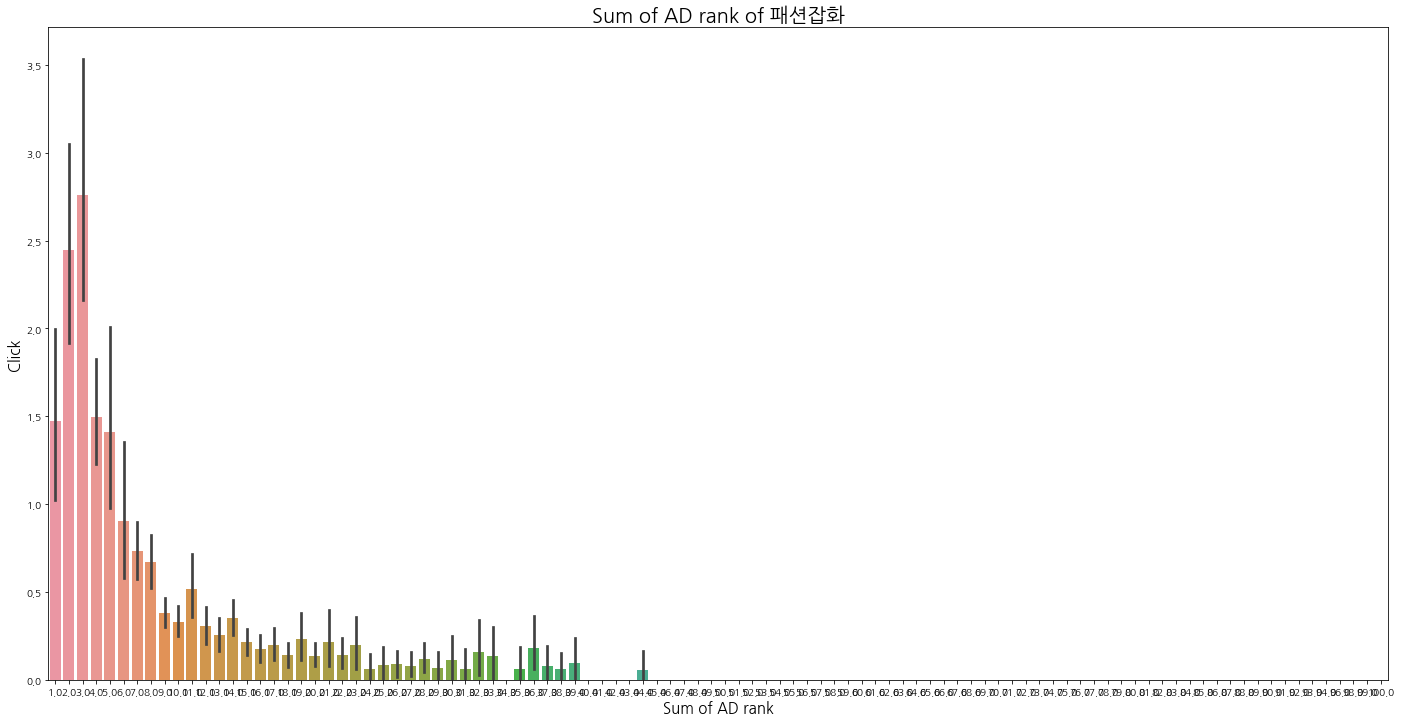

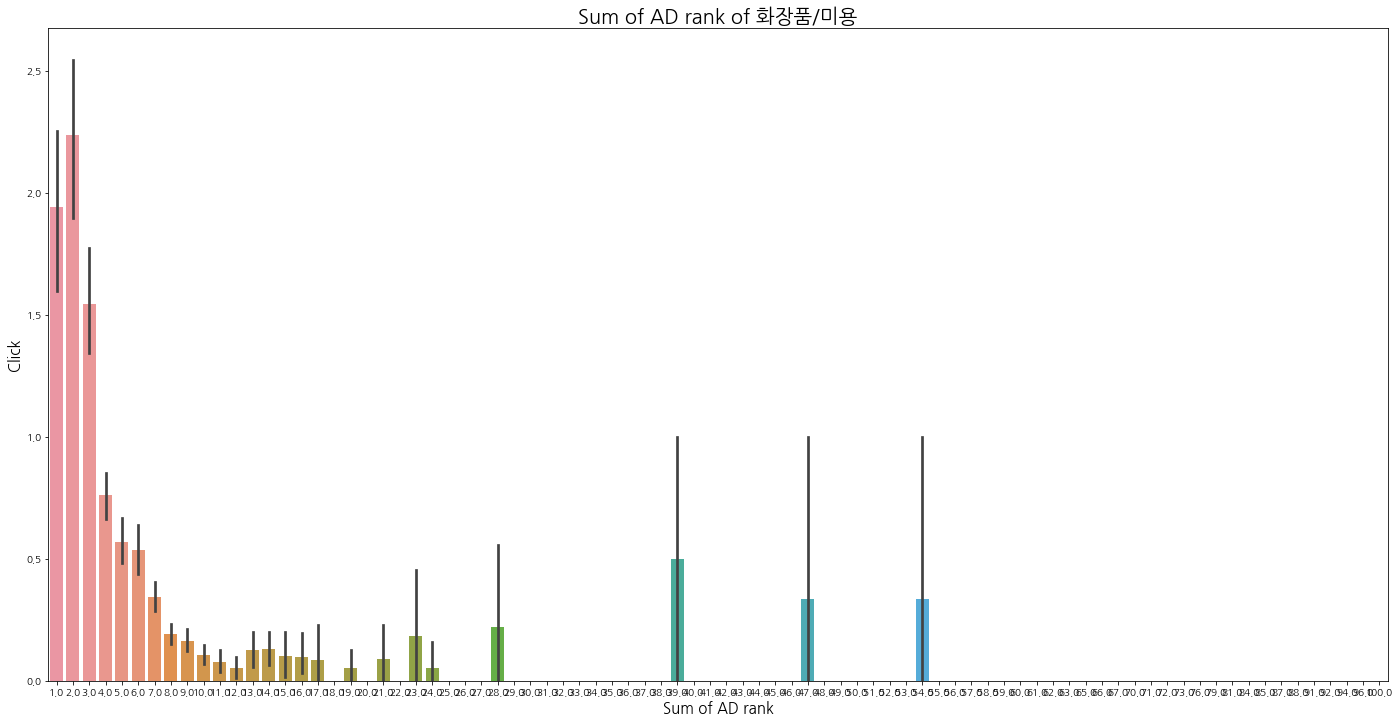

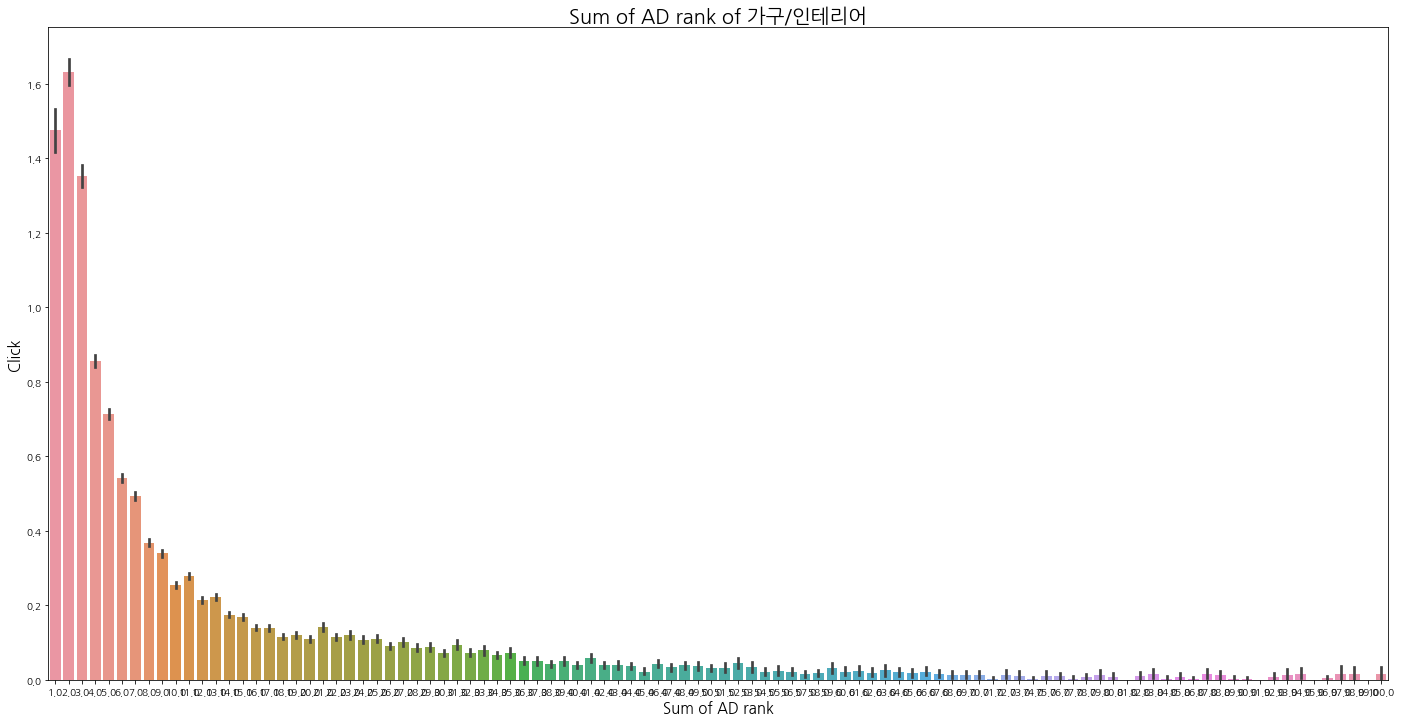

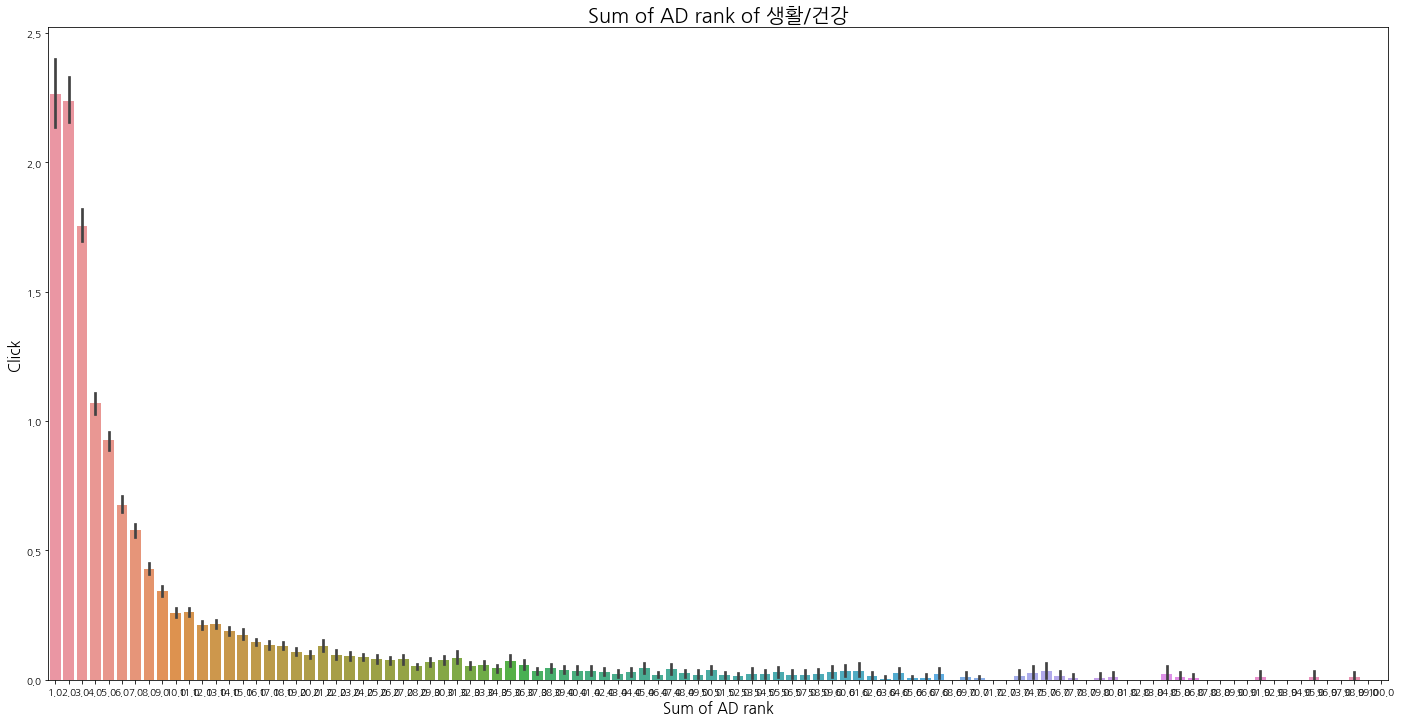

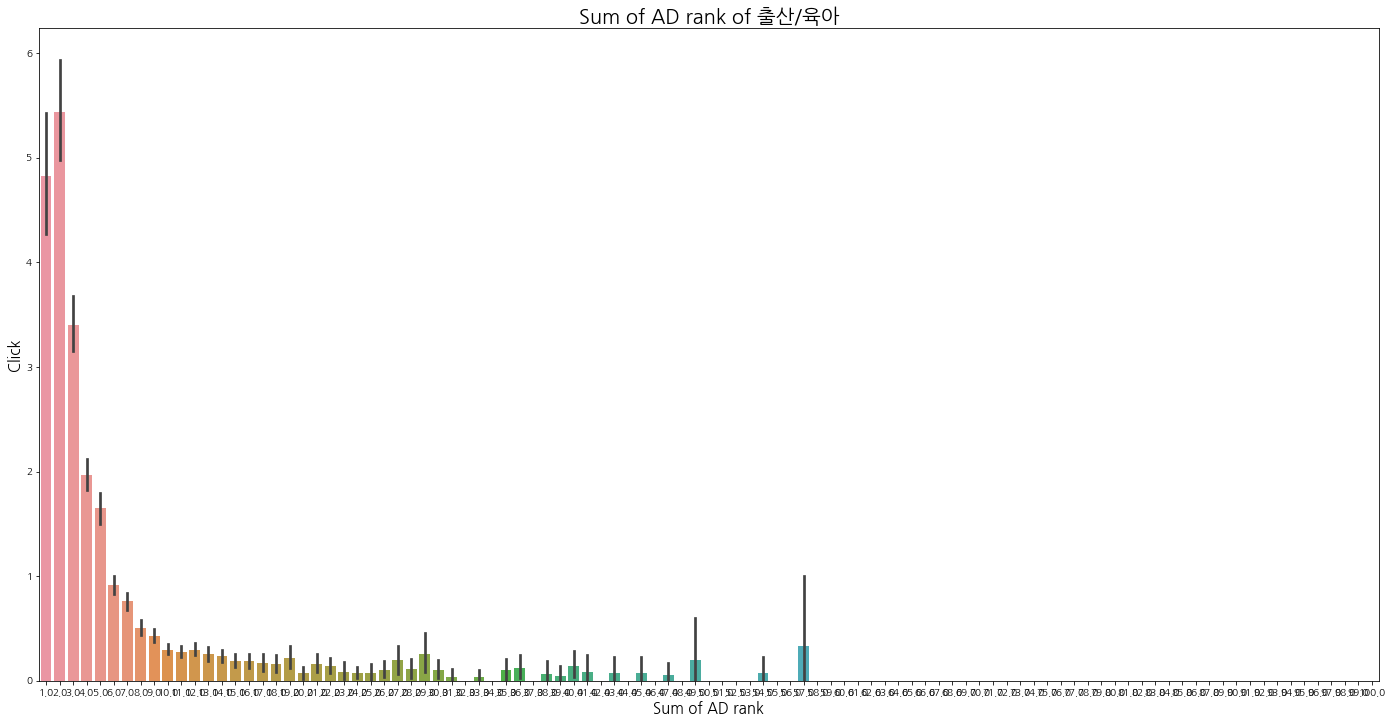

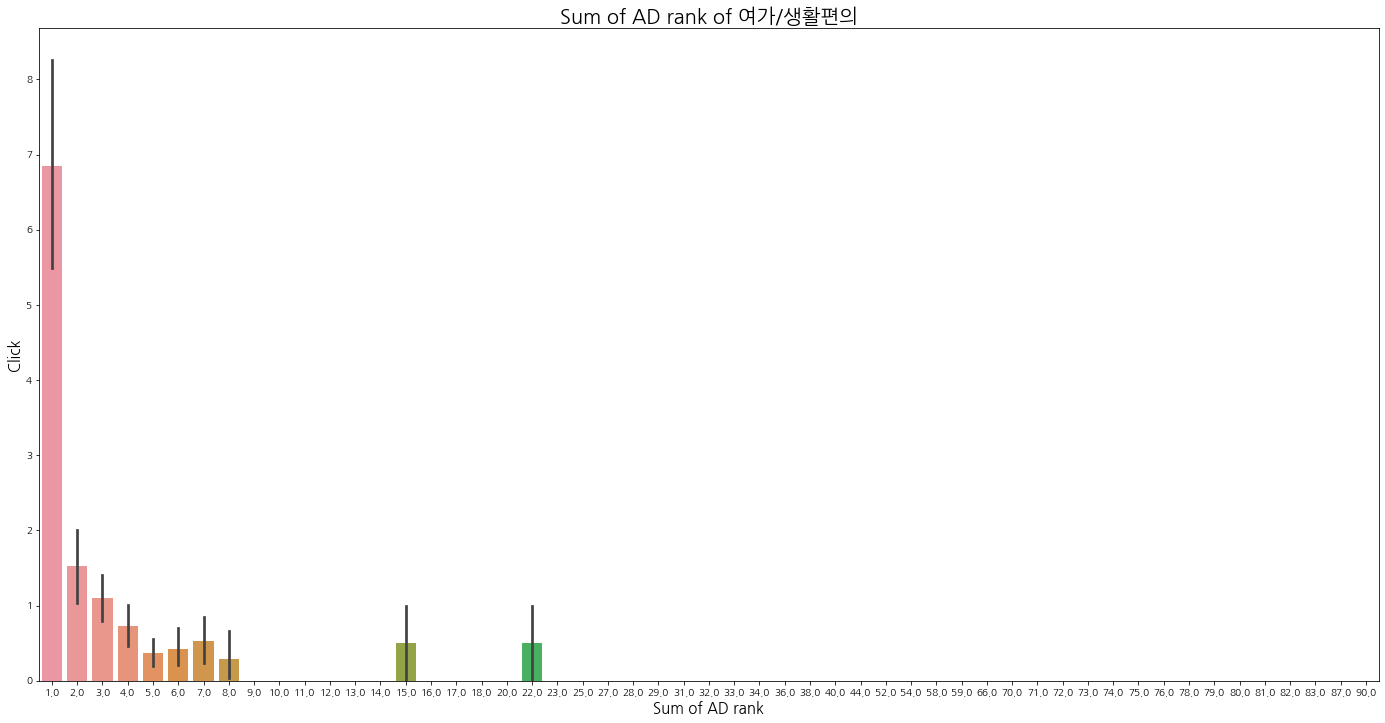

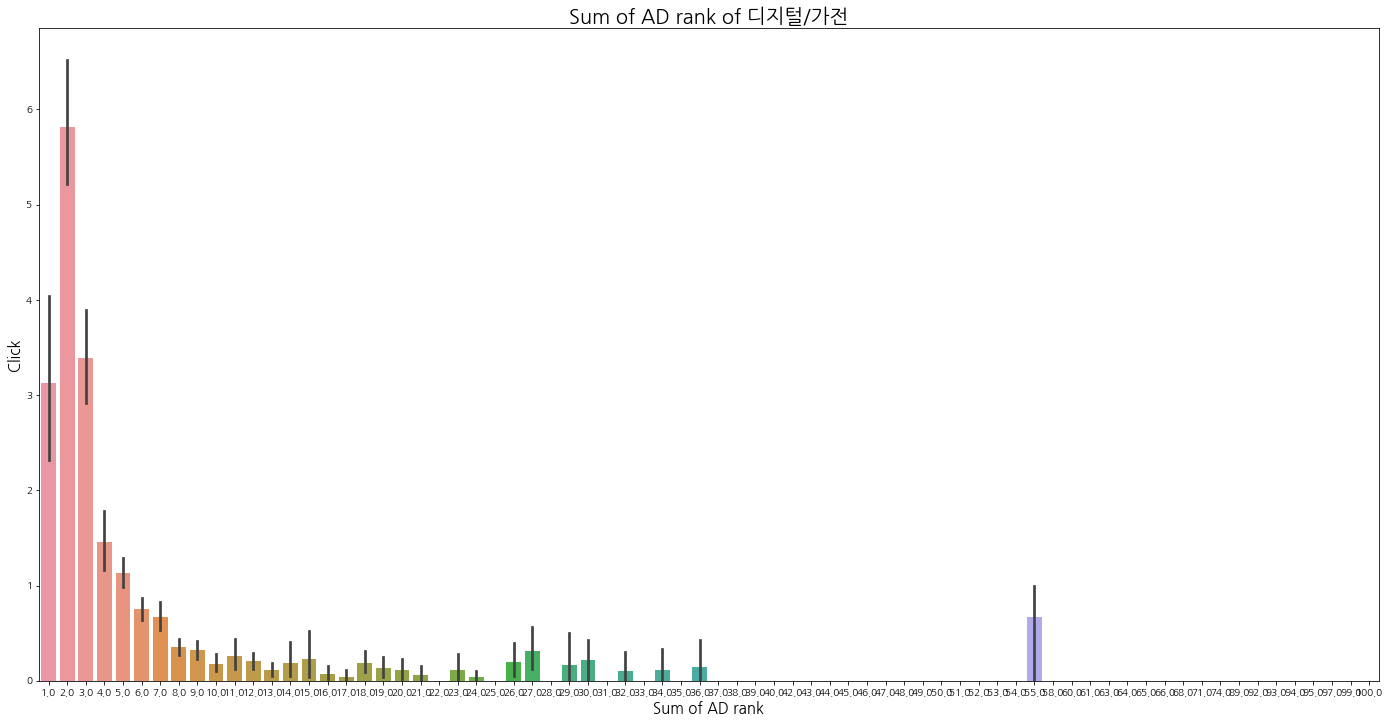

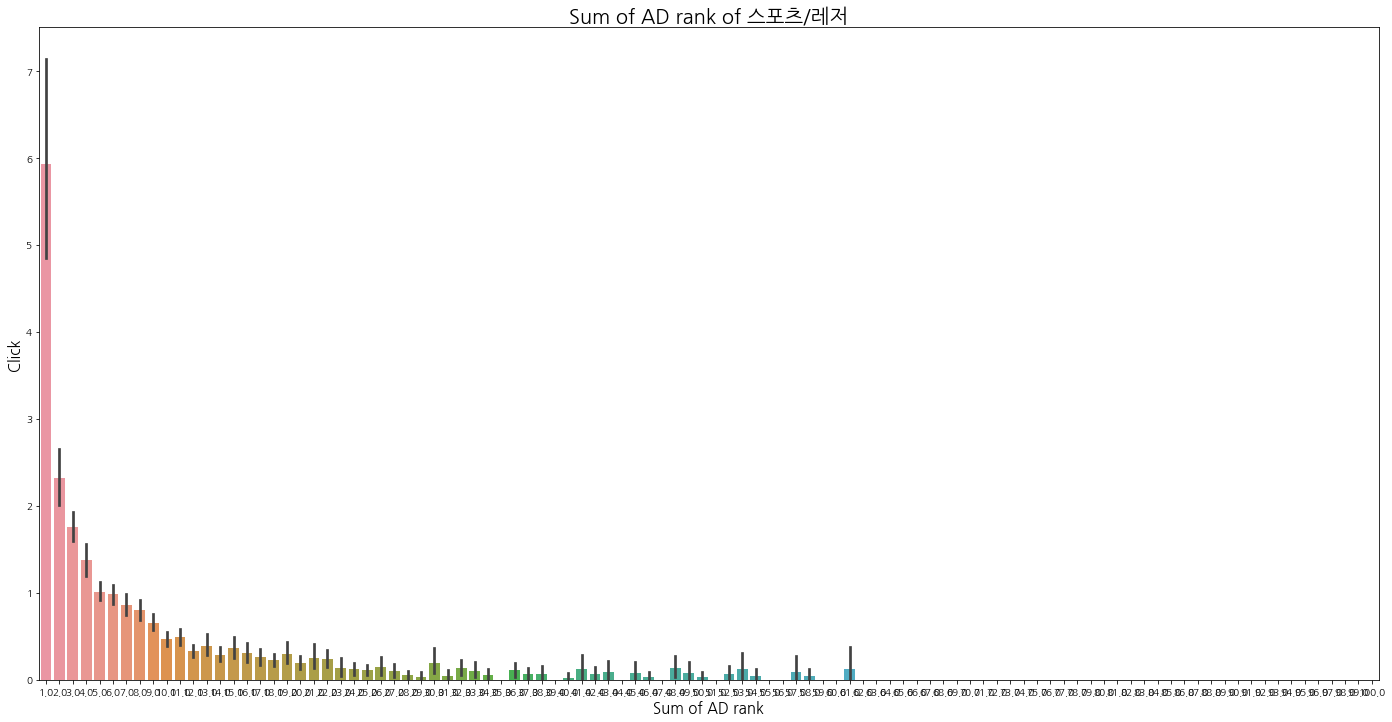

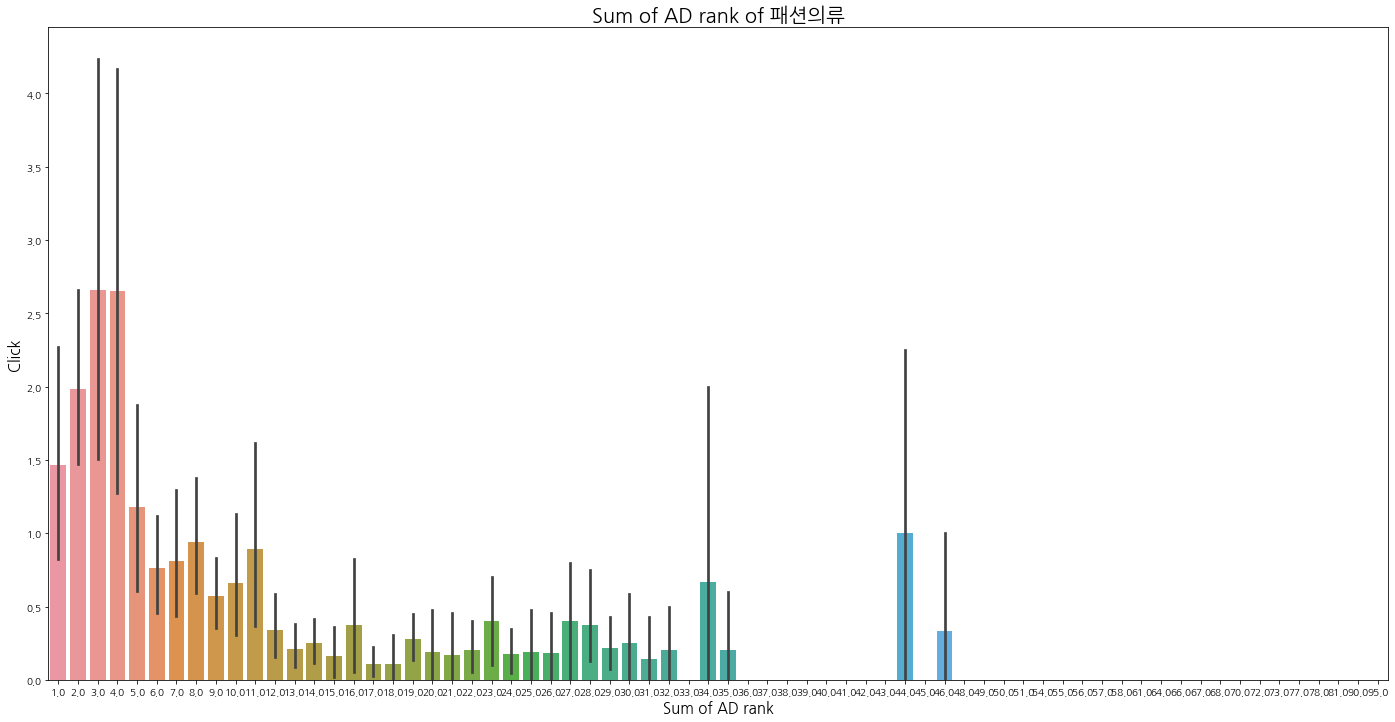

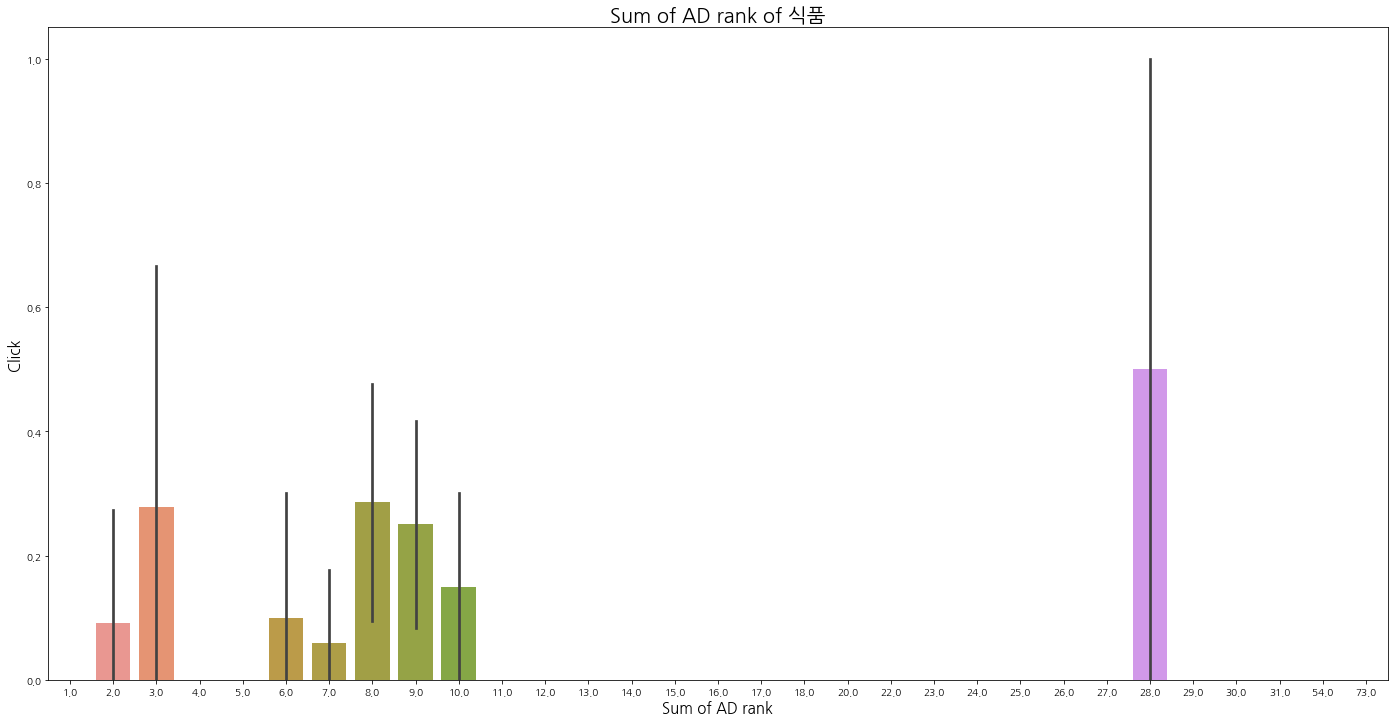

In [29]:
for key, df in group_df.items():
    barplot_df(df, name=key)

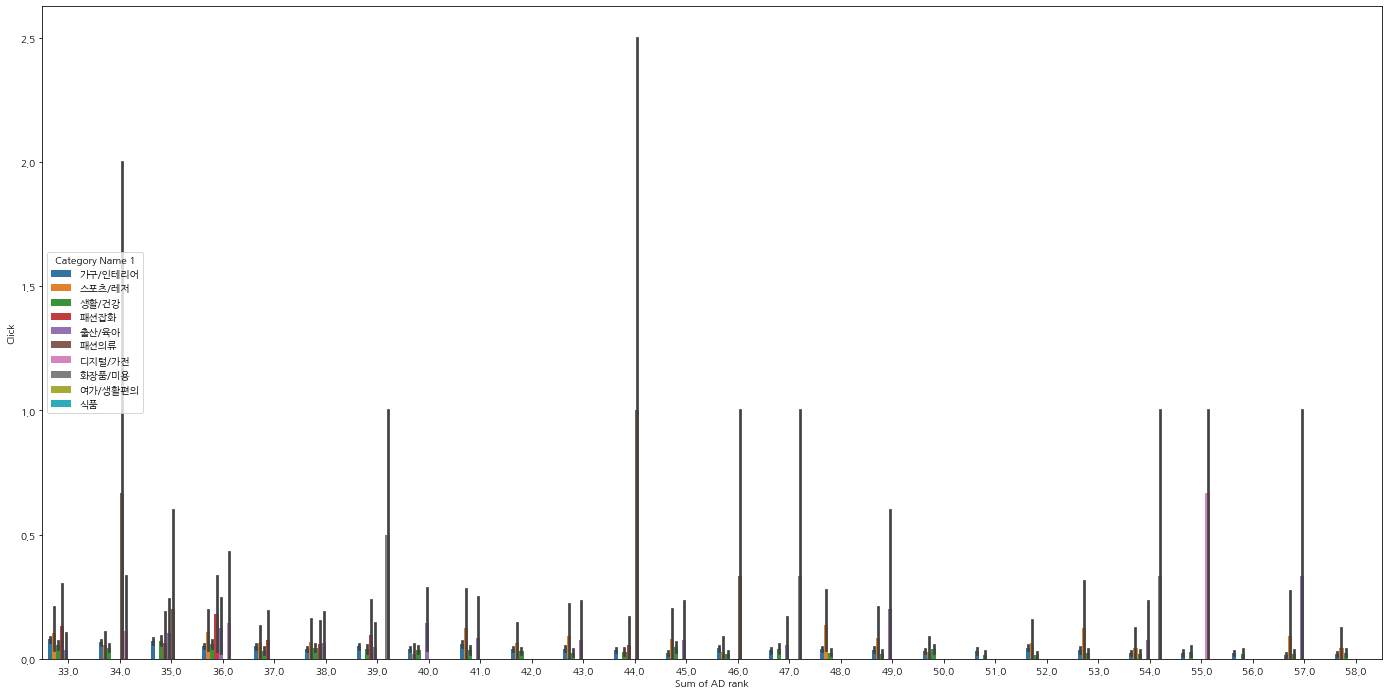

In [30]:
bidding_rank_filtered = bidding_rank[(bidding_rank['Sum of AD rank'] >= 33) & (bidding_rank['Sum of AD rank'] <= 58)]
plt.figure(figsize=(24, 12))  # set the size of the figure to be 12 inches wide and
sns.barplot(x='Sum of AD rank', y='Click', hue='Category Name 1', data=bidding_rank_filtered)
plt.show()


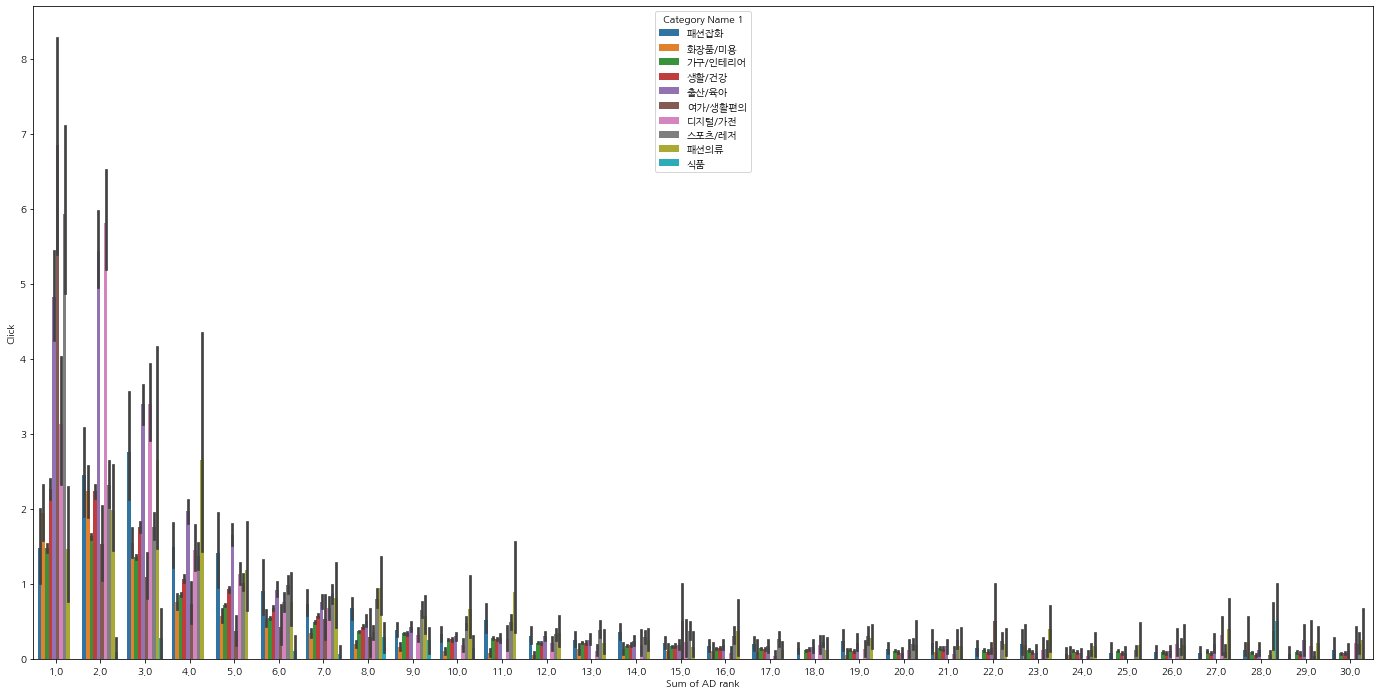

In [31]:
bidding_rank_filtered = bidding_rank[bidding_rank["Sum of AD rank"] <= 30]
plt.figure(figsize=(24, 12))  # set the size of the figure to be 12 inches wide and
sns.barplot(x='Sum of AD rank', y='Click', hue='Category Name 1', data=bidding_rank_filtered)
plt.show()

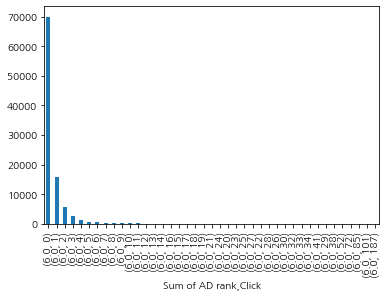

In [32]:
bidding_rank[bidding_rank["Sum of AD rank"] == 6].groupby("Sum of AD rank")["Click"].value_counts().plot.bar() # A


In [33]:
bidding_rank[(bidding_rank['Category Name 1'] == '패션잡화') & (bidding_rank["Sum of AD rank"] == 6) & (bidding_rank["Click"] >= 1)].groupby("Sum of AD rank")["Click"].value_counts() #패션잡화 6위일때 상위 20%로보기

Sum of AD rank  Click
6.0             1        104
                2         33
                3         26
                5          6
                4          4
                9          2
                15         2
                7          1
                8          1
                11         1
                13         1
                14         1
                72         1
                85         1
Name: Click, dtype: int64

In [34]:
bidding_rank[(bidding_rank['Category Name 1'] == '화장품/미용') & (bidding_rank["Sum of AD rank"] == 4) & (bidding_rank["Click"] >= 1)].groupby("Sum of AD rank")["Click"].value_counts() #패션잡화 6위일때 상위 20%로보기

Sum of AD rank  Click
4.0             1        168
                2         71
                3         27
                4         16
                5         10
                6          5
                7          3
                9          2
                10         1
                11         1
                14         1
Name: Click, dtype: int64

In [155]:
cosmetic = bidding_rank[(bidding_rank['Category Name 1'] == '화장품/미용') & (bidding_rank["Sum of AD rank"] > 4) & (bidding_rank["Click"] >= 1)]
cosmetic

,index,Impression,Click,Cost,Sum of AD rank,Bid,Price(PC),Price(Mobile),Delivery Fee,Category Name 1,Category Name 2,Category Name 3,Category Name 4,CTR,CPC,CPM
423636,4541465,50,2,840.0,5.0,350,10320,10320,0,화장품/미용,바디케어,바디클렌저,uncategory,4.000000,420.0,0.84
423642,4541454,12,1,210.0,5.0,300,12700,12700,0,화장품/미용,바디케어,바디로션,uncategory,8.333333,210.0,0.21
423898,4541471,64,2,420.0,5.0,240,19800,19800,3000,화장품/미용,바디케어,바디클렌저,uncategory,3.125000,210.0,0.42
423915,4541455,58,2,680.0,5.0,480,8900,8900,0,화장품/미용,바디케어,핸드케어,uncategory,3.448276,340.0,0.68
423947,4541468,118,1,50.0,5.0,150,98000,98000,0,화장품/미용,바디케어,핸드케어,uncategory,0.847458,50.0,0.05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1217248,3592032,2,1,190.0,28.0,210,7900,7900,3000,화장품/미용,스킨케어,에센스,uncategory,50.000000,190.0,0.19
1221128,4541466,5,1,50.0,28.0,50,17800,17800,0,화장품/미용,바디케어,바디클렌저,uncategory,20.000000,50.0,0.05
1268224,4542193,7,1,130.0,39.0,350,23450,23450,0,화장품/미용,헤어케어,샴푸,uncategory,14.285714,130.0,0.13
1289279,4542193,3,1,230.0,47.0,350,23450,23450,0,화장품/미용,헤어케어,샴푸,uncategory,33.333333,230.0,0.23


In [162]:
cosmetic_B = bidding_rank[(bidding_rank['Category Name 1'] == '화장품/미용') & (bidding_rank["Sum of AD rank"] <= 4) & (bidding_rank["Click"] >= 1)]
cosmetic_B #1~4등

,index,Impression,Click,Cost,Sum of AD rank,Bid,Price(PC),Price(Mobile),Delivery Fee,Category Name 1,Category Name 2,Category Name 3,Category Name 4,CTR,CPC,CPM
404,3592077,39,1,310.0,1.0,50,14900,14900,3000,화장품/미용,헤어케어,트리트먼트,uncategory,2.564103,310.0,0.31
410,9849669,3,1,50.0,1.0,50,11000,11000,3000,화장품/미용,스킨케어,에센스,uncategory,33.333333,50.0,0.05
481,9849669,6,2,100.0,1.0,50,11000,11000,3000,화장품/미용,스킨케어,에센스,uncategory,33.333333,50.0,0.10
511,3894177,59,6,300.0,1.0,50,8900,8900,2500,화장품/미용,바디케어,바디미스트,uncategory,10.169492,50.0,0.30
600,112618,47,4,270.0,1.0,250,49000,49000,0,화장품/미용,뷰티소품,페이스소품,마사지도구,8.510638,67.5,0.27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421817,3592070,14,1,50.0,4.0,50,9900,9900,3000,화장품/미용,헤어케어,샴푸,uncategory,7.142857,50.0,0.05
421927,1652517,36,1,550.0,4.0,50,13700,13700,0,화장품/미용,헤어케어,샴푸,uncategory,2.777778,550.0,0.55
421992,7827039,48,3,180.0,4.0,150,10500,10500,0,화장품/미용,바디케어,바디미스트,uncategory,6.250000,60.0,0.18
422282,3592062,7,1,340.0,4.0,50,7900,7900,3000,화장품/미용,헤어케어,샴푸,uncategory,14.285714,340.0,0.34


In [160]:
cosmetic['CTR'].mean()

5.285167811606388

In [164]:
cosmetic_B['CTR'].mean() # CTR 차이가 별로 없음 ->why?

6.214630521425501

In [167]:
cosmetic['CPC'].mean()

185.035755042425

In [177]:
cosmetic_B['CPC'].mean()

168.05092333689626

In [172]:
cosmetic['Cost'].mean() 

362.2348484848485

In [171]:
cosmetic_B['Cost'].mean()

787.372634643377

In [175]:
cosmetic['Impression'].mean()

82.27020202020202

In [176]:
cosmetic_B['Impression'].mean()

108.6193595342067

In [173]:
cosmetic_B['Price(Mobile)'].mean()

21068.369723435226

In [174]:
cosmetic['Price(Mobile)'].mean()  #가격차이 도 안나 근데 왜 상위 1~4위는 클릭률이 높을까?

25568.68686868687

In [145]:
Clothes = bidding_rank[(bidding_rank['Category Name 1'] == '패션의류') & (bidding_rank["Sum of AD rank"] == 44) & (bidding_rank["Click"] >= 1)]
Clothes

,index,Impression,Click,Cost,Sum of AD rank,Bid,Price(PC),Price(Mobile),Delivery Fee,Category Name 1,Category Name 2,Category Name 3,Category Name 4,CTR,CPC,CPM
1280886,3768329,30,3,360.0,44.0,150,24900,24900,3000,패션의류,여성언더웨어/잠옷,잠옷/홈웨어,uncategory,10.000000,120.0,0.36
1283078,5368281,12,1,80.0,44.0,80,24900,24900,3000,패션의류,여성언더웨어/잠옷,잠옷/홈웨어,uncategory,8.333333,80.0,0.08


In [149]:
Clothes = bidding_rank[(bidding_rank['Category Name 1'] == '패션의류') & (bidding_rank["Sum of AD rank"] == 2) & (bidding_rank["Click"] >= 1)]
Clothes['Impression'].mean()

184.1

In [37]:
bidding_rank[(bidding_rank['Category Name 1'] == '화장품/미용') & (bidding_rank["Sum of AD rank"] == 4) & (bidding_rank["Click"] >= 1)]["CTR"].value_counts() #Click


7.142857    9
4.347826    8
5.555556    8
3.225806    7
2.631579    7
           ..
1.351351    1
1.657459    1
3.125000    1
0.487805    1
1.744186    1
Name: CTR, Length: 156, dtype: int64

In [38]:
def test2(category):
    df = bidding_rank.loc[bidding_rank['Sum of AD rank'] == 6 ]
    print(df.loc[bidding_rank['Category Name 1'] == category, 'CTR'].mean())

In [39]:
test2('패션잡화')

2.1641842468781642


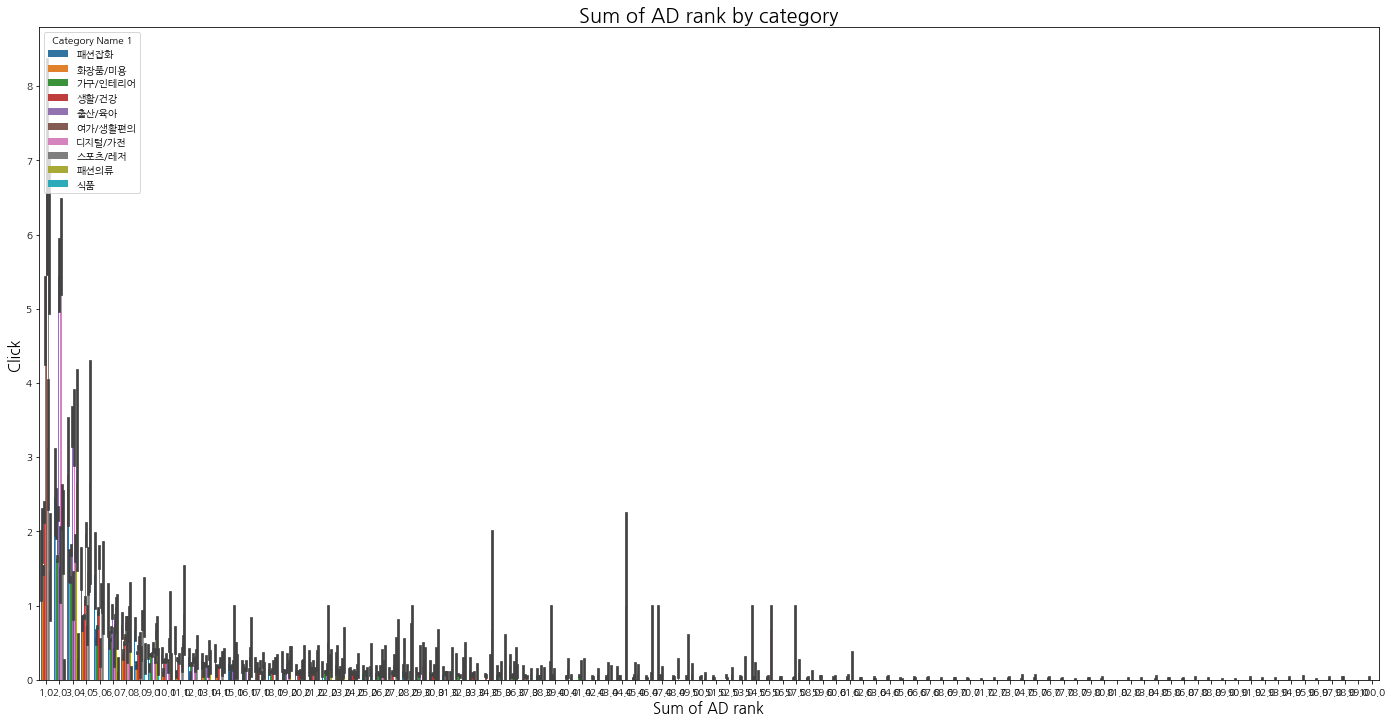

In [40]:
plt.figure(figsize=(24, 12))  # set the size of the figure to be 12 inches wide and
sns.barplot(x='Sum of AD rank', y='Click', hue='Category Name 1', data=bidding_rank)
plt.title("Sum of AD rank by category", fontsize=20)
plt.xlabel("Sum of AD rank", fontsize=15)
plt.ylabel("Click", fontsize=15)
plt.show()

In [41]:
bidding_rank[bidding_rank["Sum of AD rank"] == 100].groupby("Sum of AD rank")["Category Name 2"].value_counts() # 광고비가 제일 많이 들어간 것은 침실가구,

Sum of AD rank  Category Name 2
100.0           침실가구               46
                주방용품               38
                거실가구               27
                주방가구               25
                수납가구               23
                커튼/블라인드            21
                인테리어소품             18
                서재/사무용가구           13
                청소용품               11
                카페트/러그              9
                홈데코                 7
                DIY자재/용품            5
                생활용품                5
                수납/정리용품             5
                침구단품                5
                문구/사무용품             4
                캠핑                  4
                공구                  3
                반려동물                3
                욕실용품                3
                주얼리                 3
                세탁용품                2
                원예/식물               2
                건강관리용품              1
                남성신발                1
                모니

In [42]:
bidding_rank[bidding_rank["Sum of AD rank"] == 2].groupby("Sum of AD rank")["Category Name 3"].value_counts() # 광고비가 제일 많이 들어간 것은 침실가구,

Sum of AD rank  Category Name 3
2.0             소파                 7240
                식탁/의자              7016
                침대                 5572
                식기                 4803
                커튼                 4556
                                   ... 
                쿨매트                   1
                클렌징크림                 1
                파마약                   1
                페인트용품                 1
                힙시트                   1
Name: Category Name 3, Length: 455, dtype: int64

In [43]:
bidding_rank[bidding_rank["Sum of AD rank"] == 2].groupby("Sum of AD rank")["Category Name 1"].value_counts()[:10]

Sum of AD rank  Category Name 1
2.0             가구/인테리어            90790
                생활/건강              33958
                출산/육아               3751
                스포츠/레저              1725
                화장품/미용               956
                디지털/가전               793
                패션잡화                 566
                패션의류                 217
                여가/생활편의              181
                식품                    11
Name: Category Name 1, dtype: int64

In [44]:
bidding_rank[bidding_rank["Sum of AD rank"] == 3].groupby("Category Name 1")["Category Name 2"].value_counts()[:10] # A

Category Name 1  Category Name 2
가구/인테리어          침실가구               14942
                 거실가구               11505
                 주방가구                8419
                 인테리어소품              8123
                 서재/사무용가구            8023
                 수납가구                4598
                 커튼/블라인드             4157
                 침구단품                3213
                 카페트/러그              3105
                 홈데코                 2196
Name: Category Name 2, dtype: int64

In [45]:
bidding_rank[bidding_rank["Sum of AD rank"] >= 5].groupby("Sum of AD rank")["Cost"].mean()[:10] # B

Sum of AD rank
5.0     214.882991
6.0     158.937013
7.0     147.214796
8.0     108.420377
9.0      94.896310
10.0     72.892972
Name: Cost, dtype: float64

In [46]:
bidding_rank[bidding_rank["Sum of AD rank"] >= 5].groupby("Sum of AD rank")["Impression"].mean()[:10] # B


Sum of AD rank
5.0     48.662604
6.0     40.295189
7.0     39.800962
8.0     32.444396
9.0     30.422775
10.0    23.736753
Name: Impression, dtype: float64

In [47]:
bidding_rank[bidding_rank["Sum of AD rank"] >= 5].groupby("Sum of AD rank")["CTR"].mean()# B


Sum of AD rank
5.0      1.698055
6.0      1.515973
7.0      1.363668
8.0      1.220257
9.0      1.167487
           ...   
96.0     0.126582
97.0     1.060071
98.0     1.129032
99.0     0.000000
100.0    0.566893
Name: CTR, Length: 96, dtype: float64

In [48]:
def test(category):
    df = bidding_rank.loc[bidding_rank['Sum of AD rank'] <= 4]
    print(df.loc[bidding_rank['Category Name 1'] == category, 'CTR'].mean())

In [49]:
#Design A CTR 확인
test('가구/인테리어')
test('생활/건강')
test('출산/육아')
#category 순위에서 어떤품목이 1등일까

2.461420578189372
2.8264950081946005
3.34307822055886


In [50]:
bidding_rank[bidding_rank["Sum of AD rank"] >= 5].groupby("Sum of AD rank")["Cost"].mean()[:10] # B

Sum of AD rank
5.0     214.882991
6.0     158.937013
7.0     147.214796
8.0     108.420377
9.0      94.896310
10.0     72.892972
Name: Cost, dtype: float64

In [51]:
bidding_rank[bidding_rank["Sum of AD rank"] == 5].groupby("Sum of AD rank")["Category Name 1"].value_counts()[:10] # B
# 1~5등(A에서는 Category Name 2 침실가구가 높은 반면, 5~10등은 가구/인테리어가 높았다. )

Sum of AD rank  Category Name 1
5.0             가구/인테리어            67310
                생활/건강              22815
                출산/육아               2165
                스포츠/레저              1147
                화장품/미용               773
                패션잡화                 578
                디지털/가전               548
                패션의류                 182
                여가/생활편의               65
                식품                     8
Name: Category Name 1, dtype: int64

In [52]:
bidding_rank[bidding_rank["Sum of AD rank"] == 5].groupby("Category Name 1")["Category Name 2"].value_counts()[:10] # B

Category Name 1  Category Name 2
가구/인테리어          침실가구               14453
                 거실가구                9952
                 주방가구                8348
                 서재/사무용가구            8012
                 인테리어소품              6469
                 수납가구                4519
                 커튼/블라인드             3560
                 카페트/러그              3038
                 침구단품                2530
                 홈데코                 2218
Name: Category Name 2, dtype: int64

In [53]:
def test(category):
    df = bidding_rank.loc[bidding_rank['Sum of AD rank'] >= 5][:10]
    print(df.loc[bidding_rank['Category Name 1'] == category, 'CTR'].mean())

In [54]:
#Design B CTR 확인
test('가구/인테리어')
test('생활/건강')
test('출산/육아')

#1~5등에 비해 현저하게 CTR이 낮음

0.0
0.3024803387779795
1.550387596899225


In [55]:
from scipy import stats


In [56]:
#design_A = design_A.drop(columns=['index','CPC','Cost','Bid','Price(PC)','Price(Mobile)','Delivery Fee','Category Name 1','Category Name 2','Category Name 3','Category Name 4','Impression'])
rank_A = design_A['Sum of AD rank']
rank_A

0         1.0
1         1.0
2         1.0
3         1.0
4         1.0
         ... 
422705    4.0
422706    4.0
422707    4.0
422708    4.0
422709    4.0
Name: Sum of AD rank, Length: 422710, dtype: float64

In [57]:
Click_A= design_A['Click']
Click_A # A의 클릭

0         1
1         0
2         0
3         0
4         0
         ..
422705    3
422706    0
422707    0
422708    0
422709    0
Name: Click, Length: 422710, dtype: int64

In [58]:
Click_A.mean()

1.561391970854723

In [59]:
#design_B = design_B.drop(columns=['index','CPC','Cost','Bid','Price(PC)','Price(Mobile)','Delivery Fee','Category Name 1','Category Name 2','Category Name 3','Category Name 4'])
rank_B= design_B['Sum of AD rank']
rank_B.sum()

14066088.0

In [60]:
Click_B= design_B['Click']
Click_B

422710     5
422711     0
422712     0
422713     0
422714     0
          ..
1331206    0
1331207    0
1331208    0
1331209    0
1331210    0
Name: Click, Length: 908501, dtype: int64

In [61]:
Click_B.mean()

0.33124674601348814

In [62]:
rank_B

422710       5.0
422711       5.0
422712       5.0
422713       5.0
422714       5.0
           ...  
1331206    100.0
1331207    100.0
1331208    100.0
1331209    100.0
1331210    100.0
Name: Sum of AD rank, Length: 908501, dtype: float64

In [63]:
print(rank_A.sum(), Click_A.sum())
print(rank_B.sum(), Click_B.sum())

1103673.0 660016
14066088.0 300938


In [64]:
bidding_rank

,index,Impression,Click,Cost,Sum of AD rank,Bid,Price(PC),Price(Mobile),Delivery Fee,Category Name 1,Category Name 2,Category Name 3,Category Name 4,CTR,CPC,CPM
0,9190721,22,1,280.0,1.0,60,9900,9900,3000,패션잡화,여성신발,실내화,uncategory,4.545455,280.0,0.28
1,3592074,1,0,0.0,1.0,300,9900,9900,3000,화장품/미용,헤어케어,린스,uncategory,0.000000,0.0,0.00
2,3592078,3,0,0.0,1.0,50,5900,5900,3000,화장품/미용,헤어케어,헤어에센스,uncategory,0.000000,0.0,0.00
3,3044310,39,0,0.0,1.0,50,1187500,1187500,-1,가구/인테리어,주방가구,식탁/의자,식탁테이블,0.000000,0.0,0.00
4,3044301,1,0,0.0,1.0,50,799000,799000,0,가구/인테리어,주방가구,식탁/의자,식탁테이블,0.000000,0.0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1331206,3303386,1,0,0.0,100.0,360,39900,39900,-1,가구/인테리어,침실가구,협탁,uncategory,0.000000,0.0,0.00
1331207,112516,1,0,0.0,100.0,50,97900,97900,0,가구/인테리어,침실가구,화장대,콘솔,0.000000,0.0,0.00
1331208,9190741,1,0,0.0,100.0,300,15840,15840,3000,패션잡화,남성신발,슬리퍼,uncategory,0.000000,0.0,0.00
1331209,9143558,2,0,0.0,100.0,50,22900,22900,4000,가구/인테리어,서재/사무용가구,의자,스툴,0.000000,0.0,0.00


In [65]:
#1~!00등 자르기
design__50 = bidding_rank[bidding_rank['Sum of AD rank'] <= 50] 
design_100 = bidding_rank[bidding_rank['Sum of AD rank'] >= 51] 

In [66]:
design__50['Impression'].mean()

45.41886428204372

In [67]:
design_100['Impression'].mean()

2.3771777746198666

In [68]:
design__50['Click'].mean()

0.7410121401885456

In [69]:
design_100['Click'].mean()

0.01656956089242575

In [70]:
design__50['CTR'].mean()

1.705337291009736

In [71]:
design_100['CTR'].mean()

0.6676726271576163

In [72]:
design__50['Cost'].mean()

185.55248120022284

In [73]:
design_100['Cost'].mean()

4.029273838283359

In [74]:
design__50['Delivery Fee'].mean()

2000.6552075344168

In [75]:
design_100['Delivery Fee'].mean()

1978.1095068921416

In [76]:
design__50['Category Name 1'].value_counts() #

가구/인테리어    928822
생활/건강      302968
출산/육아       24757
스포츠/레저      15495
패션잡화         7569
화장품/미용       7400
디지털/가전       5694
패션의류         2299
여가/생활편의       814
식품            208
Name: Category Name 1, dtype: int64

In [77]:
design_100['Category Name 1'].value_counts() #

가구/인테리어    25075
생활/건강       9041
스포츠/레저       481
패션잡화         219
출산/육아        200
화장품/미용        71
디지털/가전        40
패션의류          32
여가/생활편의       24
식품             2
Name: Category Name 1, dtype: int64

###1~64등


In [78]:
design_32 = bidding_rank[bidding_rank['Sum of AD rank'] <= 32] 
design_64 = bidding_rank[(bidding_rank['Sum of AD rank'] >= 33) & (bidding_rank['Sum of AD rank'] <= 64)]

In [79]:
design_32['Impression'].mean()

47.143666439334474

In [80]:
design_64['Impression'].mean()

4.260000575572695

In [81]:
design_32['Click'].mean()

0.7703754519835806

In [82]:
design_64['Click'].mean()

0.041729020375273394

In [83]:
design_32['CTR'].mean()

1.7326605375945185

In [84]:
design_64['CTR'].mean()

1.0069418429191674

In [85]:
design_32['Cost'].mean()

192.845212512707

In [86]:
design_64['Cost'].mean()

11.570593991021067

In [87]:
design_32['Delivery Fee'].mean()

1999.359918868143

In [88]:
design_64['Delivery Fee'].mean()

2030.7284735812134

In [89]:
design_32['Category Name 1'].value_counts() #

가구/인테리어    890617
생활/건강      290225
출산/육아       24417
스포츠/레저      14784
화장품/미용       7320
패션잡화         7195
디지털/가전       5605
패션의류         2232
여가/생활편의       805
식품            208
Name: Category Name 1, dtype: int64

In [90]:
design_64['Category Name 1'].value_counts()

가구/인테리어    50274
생활/건강      17040
스포츠/레저       950
패션잡화         480
출산/육아        424
화장품/미용       118
디지털/가전       112
패션의류          84
여가/생활편의       13
식품             1
Name: Category Name 1, dtype: int64

### 1~32등

In [91]:
design_16 = bidding_rank[bidding_rank['Sum of AD rank'] <= 16] 
design_32 = bidding_rank[(bidding_rank['Sum of AD rank'] >= 17) & (bidding_rank['Sum of AD rank'] <= 32)]

In [92]:
design_16['Impression'].mean()

52.7723022248547

In [93]:
design_32['Impression'].mean()

9.806026226609696

In [94]:
design_16['Click'].mean()

0.8699246659016029

In [95]:
design_32['Click'].mean()

0.11001424291537744

In [96]:
design_16['CTR'].mean()

1.8155053702337236

In [97]:
design_32['CTR'].mean()

1.1831080931952156

In [98]:
design_16['Cost'].mean()

216.9633324695517

In [99]:
design_32['Cost'].mean()

32.85730072196847

In [100]:
design_16['Delivery Fee'].mean()

1989.5719931144263

In [101]:
design_32['Delivery Fee'].mean()

2064.2882716958893

In [102]:
design_16['Category Name 1'].value_counts()

가구/인테리어    769233
생활/건강      254014
출산/육아       23093
스포츠/레저      12946
화장품/미용       7036
패션잡화         6108
디지털/가전       5209
패션의류         1919
여가/생활편의       781
식품            181
Name: Category Name 1, dtype: int64

In [103]:
design_32['Category Name 1'].value_counts()

가구/인테리어    121384
생활/건강       36211
스포츠/레저       1838
출산/육아        1324
패션잡화         1087
디지털/가전        396
패션의류          313
화장품/미용        284
식품             27
여가/생활편의        24
Name: Category Name 1, dtype: int64

### 1~16등 확인

In [104]:
design_8 = bidding_rank[bidding_rank['Sum of AD rank'] <= 8] 
design_16 = bidding_rank[(bidding_rank['Sum of AD rank'] >= 9) & (bidding_rank['Sum of AD rank'] <= 16)]

In [105]:
design_8['Impression'].mean()

65.07268632028436

In [106]:
design_16['Impression'].mean()

22.65515920761618

In [107]:
design_8['Click'].mean()

1.1248339713785558

In [108]:
design_16['Click'].mean()

0.2457864316876933

In [109]:
design_8['CTR'].mean()

2.087535569754123

In [110]:
design_16['CTR'].mean()

1.1494471105564579

In [111]:
design_8['Cost'].mean()

277.0252754543547

In [112]:
design_16['Cost'].mean()

69.90336159932085

In [113]:
design_8['Delivery Fee'].mean()

1970.8127483912006

In [114]:
design_16['Delivery Fee'].mean()

2035.503473939866

In [115]:
design_8['Category Name 1'].value_counts()

가구/인테리어    534381
생활/건강      188574
출산/육아       18450
스포츠/레저       9496
화장품/미용       5737
디지털/가전       4243
패션잡화         4196
패션의류         1294
여가/생활편의       720
식품             96
Name: Category Name 1, dtype: int64

In [116]:
design_16['Category Name 1'].value_counts()

가구/인테리어    234852
생활/건강       65440
출산/육아        4643
스포츠/레저       3450
패션잡화         1912
화장품/미용       1299
디지털/가전        966
패션의류          625
식품             85
여가/생활편의        61
Name: Category Name 1, dtype: int64

###1~8등

In [117]:
design_4 = bidding_rank[bidding_rank['Sum of AD rank'] <= 4] 
design_8 = bidding_rank[(bidding_rank['Sum of AD rank'] >= 5) & (bidding_rank['Sum of AD rank'] <= 8)]

In [118]:
design_4['Impression'].mean()

84.87919613919709

In [119]:
design_8['Impression'].mean()

40.7679874128026

In [120]:
design_4['Click'].mean()

1.561391970854723

In [121]:
design_8['Click'].mean()

0.5891307692530996

In [122]:
design_4['CTR'].mean()

2.592703831679

In [123]:
design_8['CTR'].mean()

1.4676402617995576

In [124]:
design_4['Cost'].mean()

371.8239928083083

In [125]:
design_8['Cost'].mean()

160.6971437860873

In [126]:
design_4['Delivery Fee'].mean()

1982.689101275106

In [127]:
design_8['Delivery Fee'].mean()

1956.2391973919885

In [128]:
design_4['Category Name 1'].value_counts()

가구/인테리어    289721
생활/건강      107581
출산/육아       11152
스포츠/레저       5398
화장품/미용       3079
디지털/가전       2447
패션잡화         2056
패션의류          696
여가/생활편의       540
식품             40
Name: Category Name 1, dtype: int64

In [129]:
design_8['Category Name 1'].value_counts()

가구/인테리어    244660
생활/건강       80993
출산/육아        7298
스포츠/레저       4098
화장품/미용       2658
패션잡화         2140
디지털/가전       1796
패션의류          598
여가/생활편의       180
식품             56
Name: Category Name 1, dtype: int64

In [130]:
design_4['Price(PC)'].mean()

179589.96985640272

In [131]:
design_8['Price(PC)'].mean()

193102.774730969

In [132]:
design_4['Price(Mobile)'].mean()

179589.96985640272

In [133]:
design_8['Price(Mobile)'].mean()

193102.774730969

In [134]:
# stats.ttest_ind(design_A,
#                 design_B,
#                 equal_var=False)
# # https://data101.oopy.io/ab-test-python-or-without-code

In [135]:
# from IPython.core.pylabtools import figsize
# from matplotlib import pyplot as plt
# from scipy import stats as st 
# import numpy as np

# visit_A = rank_A.sum()
# visit_B = rank_B.sum()

# conversion_A = Click_A.sum()
# conversion_B = Click_B.sum()

# alpha = 1
# beta  = 1
# n_samples = 1000
# print(alpha)

# posterior_A = st.beta(alpha+conversion_A,beta+visit_A-conversion_A)
# posterior_B = st.beta(alpha+conversion_B,beta+visit_B-conversion_B)
# posterior_samples_A = st.beta(alpha+conversion_A,beta+visit_A-conversion_A).rvs(n_samples)
# posterior_samples_B = st.beta(alpha+conversion_B,beta+visit_B-conversion_B).rvs(n_samples)

# # posterior mean 
# print((posterior_samples_A > posterior_samples_B).mean())

In [136]:
# # Posterior Dist of A and B
# fig,axes = plt.subplots(1,2,figsize=(10,4))
# x = np.linspace(0,1,1000)
# i=0
# for ax in axes:
#     ax.plot(x, posterior_A.pdf(x), label = "posterior of A: Beta(121,1181)")
#     ax.plot(x, posterior_B.pdf(x), label = "posterior of B: Beta(126,1151)")
#     ax.set_xlabel("Value")
#     ax.set_ylabel("Density")
#     if i==1:
#         ax.set_xlim(0.05, 0.15)
#     i+=1
# axes[0].legend()

In [137]:
purchase_counts = df.groupby(['group', 'is_purchase']).user_id.count().reset_index()


KeyError: ignored

In [ ]:
Cost_A= design_A['Cost']
Cost_A.sum()
print(rank_A.sum())

In [ ]:
Cost_B= design_B['Cost']
Cost_B.sum()

In [ ]:
from IPython.core.pylabtools import figsize
from matplotlib import pyplot as plt
from scipy import stats as st 
import numpy as np

visit_A = rank_A.sum()
visit_B = rank_B.sum()

conversion_A = Cost_A.sum()
conversion_B = Cost_B.sum()

alpha = 1
beta  = 1
n_samples = 1000
print(alpha)

posterior_A = st.beta(alpha+conversion_A,beta+visit_A-conversion_A)
posterior_B = st.beta(alpha+conversion_B,beta+visit_B-conversion_B)
posterior_samples_A = st.beta(alpha+conversion_A,beta+visit_A-conversion_A).rvs(n_samples)
posterior_samples_B = st.beta(alpha+conversion_B,beta+visit_B-conversion_B).rvs(n_samples)

# posterior mean 
print((posterior_samples_A > posterior_samples_B).mean())